## Kode 

In [2]:
import numpy as np
import time
from sklearn.neighbors import NearestNeighbors
from annoy import AnnoyIndex
import hnswlib
import faiss
from sklearn.preprocessing import StandardScaler

# -------------------------------
# Contoh dataset kecil untuk testing
# -------------------------------
np.random.seed(42)
n_samples = 10000   # jumlah database vector
d = 128             # dimensi
X = np.random.random((n_samples, d)).astype('float32')

# Standarisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k = 10  # jumlah nearest neighbors

# -------------------------------
# Exact NN (brute-force)
# -------------------------------
start = time.time()
nn = NearestNeighbors(n_neighbors=k, algorithm='brute', metric='euclidean')
nn.fit(X_scaled)
dist_exact, idx_exact = nn.kneighbors(X_scaled)
time_exact = time.time() - start
print(f"Exact NN done in {time_exact:.3f} s")

# -------------------------------
# Annoy
# -------------------------------
start = time.time()
f = X_scaled.shape[1]
index_annoy = AnnoyIndex(f, 'euclidean')
for i, v in enumerate(X_scaled):
    index_annoy.add_item(i, v)
index_annoy.build(10)
idx_annoy = [index_annoy.get_nns_by_vector(v, k) for v in X_scaled]
time_annoy = time.time() - start
print(f"Annoy done in {time_annoy:.3f} s")

# -------------------------------
# HNSW
# -------------------------------
start = time.time()
p_hnsw = hnswlib.Index(space='l2', dim=d)
p_hnsw.init_index(max_elements=n_samples, ef_construction=200, M=16)
p_hnsw.add_items(X_scaled)
p_hnsw.set_ef(200)
idx_hnsw, _ = p_hnsw.knn_query(X_scaled, k=k)
time_hnsw = time.time() - start
print(f"HNSW done in {time_hnsw:.3f} s")

# -------------------------------
# FAISS IVF
# -------------------------------
start = time.time()
quantizer = faiss.IndexFlatL2(d)
index_faiss = faiss.IndexIVFFlat(quantizer, d, 100, faiss.METRIC_L2)
index_faiss.train(X_scaled)
index_faiss.add(X_scaled)
index_faiss.nprobe = 10
_, idx_faiss = index_faiss.search(X_scaled, k)
time_faiss = time.time() - start
print(f"FAISS IVF done in {time_faiss:.3f} s")

# -------------------------------
# Tampilkan ringkasan waktu
# -------------------------------
print("\n=== Ringkasan Waktu (detik) ===")
print(f"Exact NN : {time_exact:.3f}")
print(f"Annoy    : {time_annoy:.3f}")
print(f"HNSW     : {time_hnsw:.3f}")
print(f"FAISS    : {time_faiss:.3f}")


Exact NN done in 0.395 s
Annoy done in 0.574 s
HNSW done in 0.959 s
FAISS IVF done in 0.253 s

=== Ringkasan Waktu (detik) ===
Exact NN : 0.395
Annoy    : 0.574
HNSW     : 0.959
FAISS    : 0.253


Pada aplikasi di android:

![WhatsApp Image 2025-10-20 at 18.34.43_e4049fdb.jpg](<attachment:WhatsApp Image 2025-10-20 at 18.34.43_e4049fdb.jpg>)
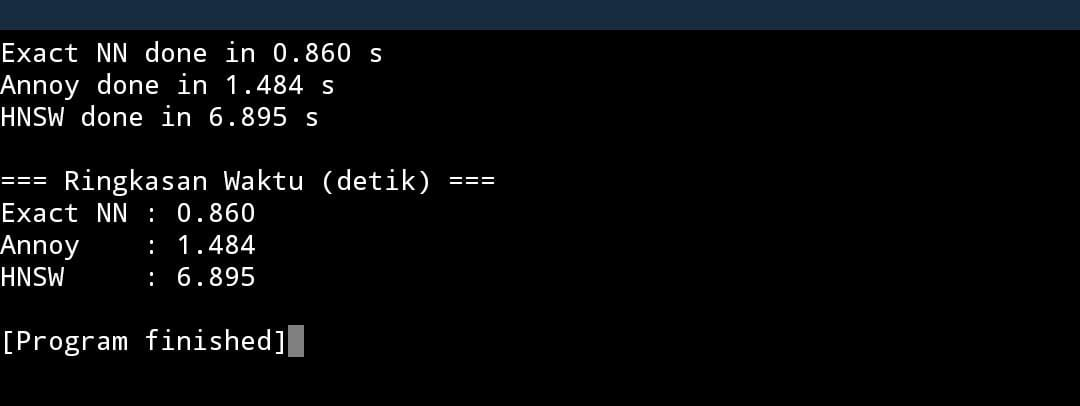

| Metode   | Notebook (VcCode) (s) | PyDroid3 (s)     | Analisis                                                 |
| -------- | --------------------- | ---------------- | -------------------------------------------------------- |
| Exact NN | 0.395                 | 0.860            | Sedikit lebih lambat di HP, karena prosesor lebih lemah  |
| Annoy    | 0.574                 | 1.484            | Performa masih baik, tapi 2–3× lebih lambat di HP        |
| HNSW     | 0.959                 | 6.895            | Paling berat di HP karena banyak operasi graf dan memori |
| FAISS    | 0.253                 | —                | Tidak didukung di PyDroid3                               |


Spesifikasi Android: 
- Smartphone: [Redmi Note Pro 12 5G]
- RAM: 8 GB
- Android: 14
- Library faiss tidak didukung di PyDroid3.